# Inbound Tourist Prediction - Multi_head_Attention


 * Multi-head CNN(5- head CNN)

In [1]:
# 전처리기
from utils.data_loader import DataLoader
from utils.spliter import WindowGenerator
from utils.vectorization import Vectorization

# 학습 효율성
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# 모델
from models.multi_head_cnn import Attention, FiveMultiHead_Attention

# Optimizer
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

# 시각화
from utils.plot_util import plot

#evaluation
from utils.evaluation import MSEs, MAEs, Absolute_Error_percentage

# Dataframe
import pandas as pd
import numpy as np

## Data Load

CSV 파일로부터 데이터를 호출

사용하고자하는 특징의 속성 이름을 리스트로 전달

학습데이터와 평가 데이터를 분할하고자하는 날짜를 입력

```python3
utils.data_loader.load_csv(
    path: str,
    features: list,
    split_date: str,
    with_datelist=True
    
    if with_datelist:
        return train_set, test_set, [date_list, datelist_train, datelist_test]
    else:
        return train_set, test_set
)
```
* path: csv 파일 경로
* features: 사용하고자하는 특징 리스트
* split_date: Train, Test를 분리할 날짜

In [2]:
#사용할 input 설정
features = ['Total_entry', 'seoul_hotel', 'disease', 'season', 'politics']

# 30일 sequence를 입력(input_length)으로하고, 1일 후(shift), 30일(output_length)를 예측
input_length = 30
output_length = 30
shift=1


In [3]:
data_loader = DataLoader()
train, test, date_lists = data_loader.load_csv(path='./data/tourist_daily.csv', 
                                               features=np.concatenate((['Date'],features), axis=0), 
                                               split_date='2018-12-31')

## Spliting 

데이터 입력 sequence와 출력 sequence로 구성

얼마나 많은 데이터를 입력으로 사용할 것인지, 얼마나 많은 데이터를 출력으로 사용할 것인지, 그리고 얼마나 멀리 떨어지게 예측할것인지 설정

```python3
utils.spliter.WindowGenerator(
    data: numpy array,
    input_width: int,
    label_width: int,
    shift: int
)
```

In [4]:
wg = WindowGenerator(train, input_width=input_length, label_width=output_length, shift=shift)
twg = WindowGenerator(test, input_width=input_length, label_width=output_length, shift=shift)
wg

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]

### Split 수행

In [5]:
# Split을 수행
train_x, train_y = wg.split_window()
test_x, test_y = twg.split_window()

print("Train X shape: {}".format(train_x.shape))
print("Train Y shape: {}".format(train_y.shape))

print("Test X shape: {}".format(test_x.shape))
print("Test Y shape: {}".format(test_y.shape))

Train X shape: (3228, 30, 5)
Train Y shape: (3228, 30)
Test X shape: (581, 30, 5)
Test Y shape: (581, 30)


## Preprocessing

해당 train set와 test set을 Multi-head CNN 구조에 맞춰

vectorization 작업 등을 통해 재구성.

```python3
utils.vectorization.To_vector{
    train : numpy array,
    test : numpy array,
    features : array,
    vector_size : list,
    input_length : int
    
)
```

In [6]:
# 전처리할 vector의 차원 수
vector_size = {"disease" : 2,
               "season" : 4,
               "politics" : 2,
               "Total_entry" : 1,
               "seoul_hotel" : 1}

In [7]:
v = Vectorization()
train_vector, test_vector = v.To_vector(train_x, test_x, features, vector_size, input_length)

In [8]:
features

['Total_entry', 'seoul_hotel', 'disease', 'season', 'politics']

### Multi-head CNN
```python3
multi_head_cnn.FiveMultiHead(
    units_1: int,
    units_2: int, 
    output_seq: int, 
    dropout=0.25
    
    return tf.keras.Model
)
    
```

* units_1, units_2: number of hidden units.
* output_seq: output sequence length
* dropout: dropout ratio

In [9]:
# NOTE: 64개, 256개의 hidden units, 30일의 outputlength
model = FiveMultiHead_Attention(64,256,vector_size, features, output_length, dropout=0)

## Compile and Training

### Hyper-parameters

In [10]:
from keras.optimizers import Adam, RMSprop
Lr = 0.001
Optimizer = Adam(learning_rate=Lr)
Epochs = 100
Validation_split=0.2
Batch_size =4
Loss = 'mse'

### Callbacks

In [11]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
tb = TensorBoard('logs')

### Train

In [12]:
model.compile(optimizer=Optimizer, loss=Loss)

history = model.fit(train_vector,
                    train_y,
                    shuffle=True,
                    epochs=Epochs,
                    callbacks=[es, rlr, tb],
                    validation_split=Validation_split,
                    verbose=1,
                    batch_size=Batch_size)

Epoch 1/100
  1/646 [..............................] - ETA: 0s - loss: 1245041536.0000WARNING:tensorflow:From C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
646/646 [==============================] - 6s 9ms/step - loss: 485831776.0000 - val_loss: 555453760.0000
Epoch 2/100
646/646 [==============================] - 5s 8ms/step - loss: 413511776.0000 - val_loss: 452861824.0000
Epoch 3/100
646/646 [==============================] - 5s 8ms/step - loss: 385447488.0000 - val_loss: 451925568.0000
Epoch 4/100
646/646 [==============================] - 5s 8ms/step - loss: 384794592.0000 - val_loss: 450841312.0000
Epoch 5/100
646/646 [==============================] - 5s 8ms/step - loss: 380487328.0000 - val_loss: 399467904.0000
Epoch 6/100
646/646 [==============================] - 5s 8m

## Prediction

In [13]:
train_predict = model.predict(train_vector)
test_predict = model.predict(test_vector)

In [14]:
test_predict

array([[33447.02  , 35043.85  , 37148.582 , ..., 35074.336 , 35322.008 ,
        35835.96  ],
       [35042.836 , 36659.023 , 37377.855 , ..., 35382.844 , 35877.363 ,
        35875.934 ],
       [34125.07  , 35143.26  , 33956.36  , ..., 37631.07  , 38045.37  ,
        37495.82  ],
       ...,
       [ 1845.6238,  1737.4338,  1674.3267, ...,  2447.8157,  2218.7903,
         2119.0088],
       [ 1664.9539,  1534.0405,  1517.4725, ...,  2230.7395,  2076.4224,
         1993.6598],
       [ 1851.6604,  1697.4259,  1649.7247, ...,  2349.621 ,  2130.4841,
         2039.1548]], dtype=float32)

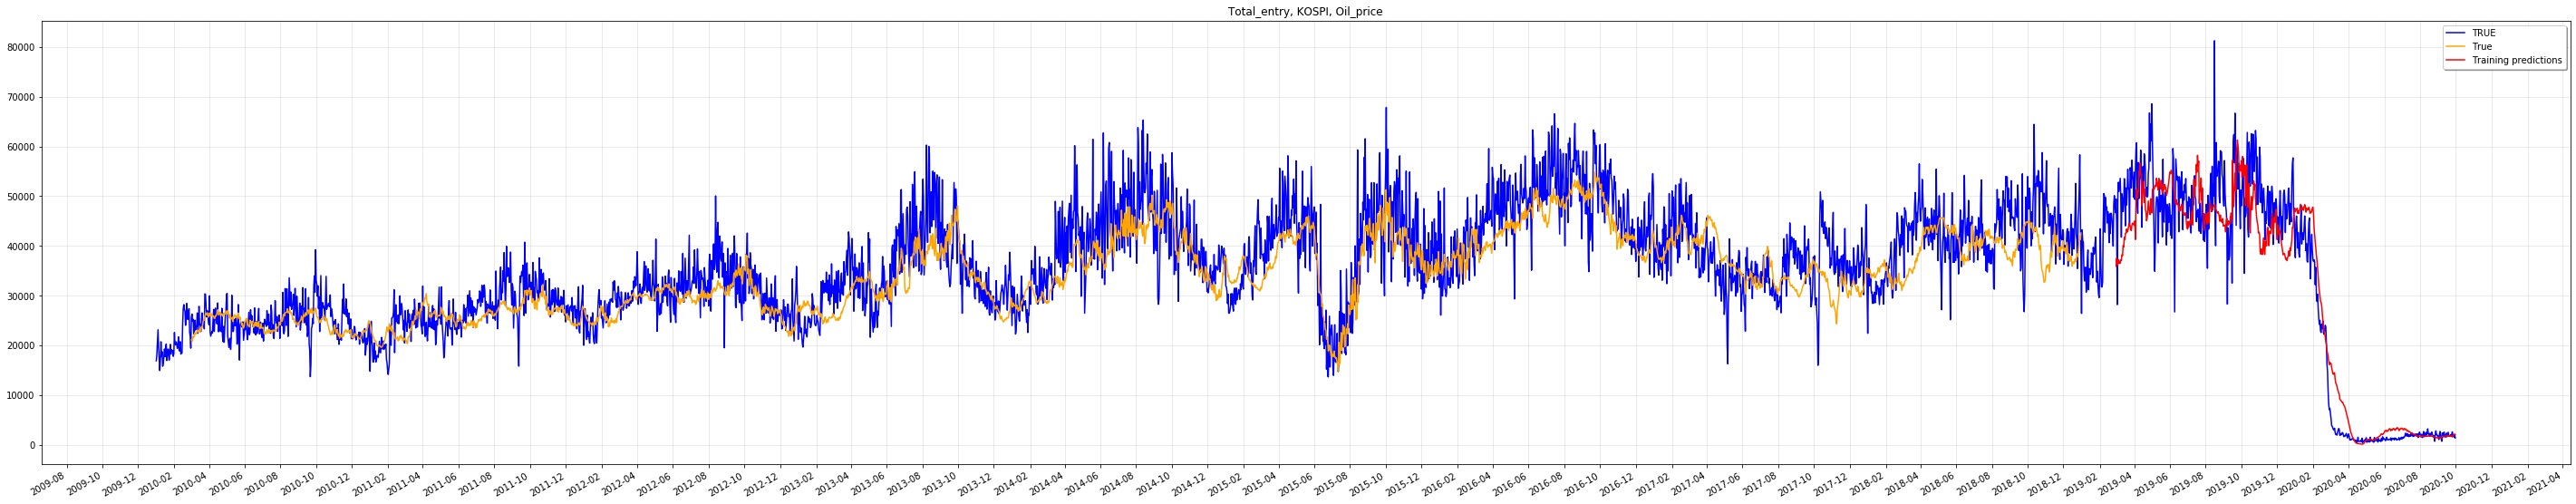

In [15]:
TRUE = pd.DataFrame(data_loader.original[:, 0:1], columns=["True"]).set_index(pd.Series(date_lists[0]))
prediction_train = wg.to_pandas(train_predict[1:][:, -1], date_lists[1], name="Train")
prediction_test = twg.to_pandas(test_predict[1:][:, -1], date_lists[2], name="Test")

plot(TRUE, prediction_train, prediction_test, show=True)

MSE, MAE 계산하기 위한 전처리

In [16]:
Train_True = TRUE.iloc[input_length + output_length:3287]
Test_True = TRUE.iloc[3286+input_length + output_length:]

In [17]:
Train_True_arr = np.array(Train_True)
Test_True_arr = np.array(Test_True)

Train_Predict_arr = np.array(prediction_train)
Test_Predict_arr = np.array(prediction_test)

print(len(Train_True_arr), len(Test_True_arr), len(Train_Predict_arr), len(Test_Predict_arr))

3227 580 3227 580


In [18]:
print("Mean Squared Error:", MSEs(Test_True_arr, Test_Predict_arr))
print("Mean Absolute Error:", MAEs(Test_True_arr, Test_Predict_arr))
print("Absolute Error Percentage:", Absolute_Error_percentage(Test_True_arr, Test_Predict_arr))

Mean Squared Error: 45429372.07201207
Mean Absolute Error: 4908.987457906789
Absolute Error Percentage: 47.236010376244025


In [21]:
date_lists[2]

[datetime.date(2018, 12, 31),
 datetime.date(2019, 1, 1),
 datetime.date(2019, 1, 2),
 datetime.date(2019, 1, 3),
 datetime.date(2019, 1, 4),
 datetime.date(2019, 1, 5),
 datetime.date(2019, 1, 6),
 datetime.date(2019, 1, 7),
 datetime.date(2019, 1, 8),
 datetime.date(2019, 1, 9),
 datetime.date(2019, 1, 10),
 datetime.date(2019, 1, 11),
 datetime.date(2019, 1, 12),
 datetime.date(2019, 1, 13),
 datetime.date(2019, 1, 14),
 datetime.date(2019, 1, 15),
 datetime.date(2019, 1, 16),
 datetime.date(2019, 1, 17),
 datetime.date(2019, 1, 18),
 datetime.date(2019, 1, 19),
 datetime.date(2019, 1, 20),
 datetime.date(2019, 1, 21),
 datetime.date(2019, 1, 22),
 datetime.date(2019, 1, 23),
 datetime.date(2019, 1, 24),
 datetime.date(2019, 1, 25),
 datetime.date(2019, 1, 26),
 datetime.date(2019, 1, 27),
 datetime.date(2019, 1, 28),
 datetime.date(2019, 1, 29),
 datetime.date(2019, 1, 30),
 datetime.date(2019, 1, 31),
 datetime.date(2019, 2, 1),
 datetime.date(2019, 2, 2),
 datetime.date(2019, 2, 